In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import astropy.coordinates as coord
import astropy.units as u
import gala.coordinates as gc
import h5py

from scipy import spatial

%matplotlib inline
np.random.seed(7649742)

In [2]:
plt.style.use('notebook')

In [3]:
f = h5py.File('../data/point_cat_ukidss.h5','r')

In [5]:
ce = coord.SkyCoord(ra=f['SKY_COORDS'][:,0]*u.deg, dec=f['SKY_COORDS'][:,1]*u.deg,
                         distance=f['DISTANCE'][:,1]*u.kpc, pm_ra_cosdec=f['PROPER_MOTION'][:,0]*u.mas/u.yr,
                         pm_dec=f['PROPER_MOTION'][:,1]*u.mas/u.yr,
                         frame='icrs')

/usr/lib64/python3.6/site-packages/astropy/coordinates/distances.py:183: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):


In [78]:
giants = (f['LOG10_SURF_GRAV'][:,1]<3.5) & ~f['FLAG_FIT'][:] & ~f['FLAG_GRID'][:]
ind_contiguous = (ce.dec<17*u.deg) & (ce.ra>120*u.deg) & (ce.ra<250*u.deg)
ind_pal5box = (ce.dec<17*u.deg) & (ce.ra>200*u.deg) & (ce.ra<250*u.deg)
ind_pm = ((ce.pm_ra_cosdec<6*u.mas/u.yr) & (ce.pm_ra_cosdec>-12*u.mas/u.yr) & (ce.pm_dec<6*u.mas/u.yr)
         & (ce.pm_dec>-12*u.mas/u.yr))

In [79]:
# create a 4D data array
data = np.vstack([ce.ra.deg, ce.dec.deg,
                  ce.pm_ra_cosdec.to(u.mas/u.yr).value,
                  ce.pm_dec.to(u.mas/u.yr).value])[:,ind_pal5box & giants & ind_pm].T
np.shape(data)

(24893, 4)

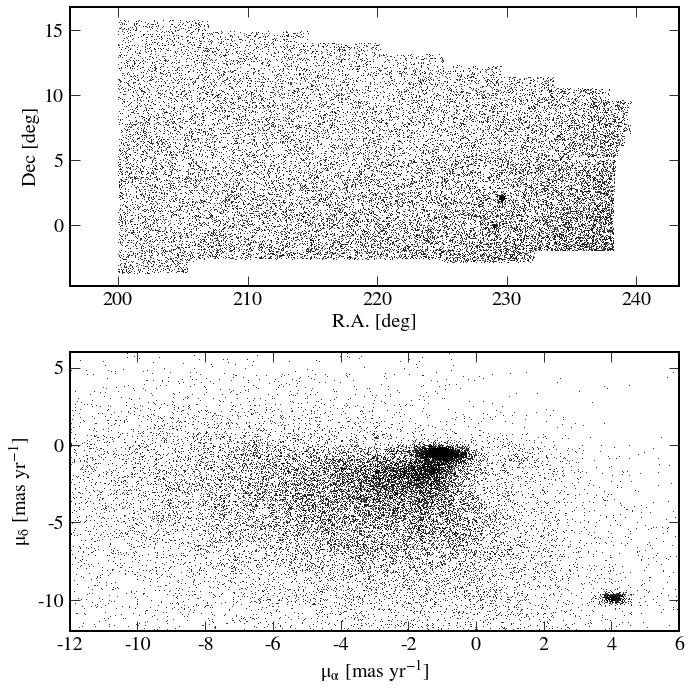

In [203]:
# check the data
fig, ax = plt.subplots(2,1,figsize=(10,10))
plt.sca(ax[0])
plt.plot(data[:,0], data[:,1], 'k.', ms=2, mec='none')
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')

plt.sca(ax[1])
plt.plot(data[:,2], data[:,3], 'k.', ms=2, mec='none')
plt.xlim(-12,6)
plt.ylim(-12,6)
plt.xlabel('$\mu_\\alpha$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_\delta$ [mas yr$^{-1}$]')

plt.tight_layout()

In [81]:
# build kd tree on positions
tree_pos = spatial.KDTree(data[:, :2])

In [84]:
# get densities
inrad = 0.015 # MAGIC
foo = tree_pos.query_pairs(inrad)
N1 = np.bincount(np.array([q for q in foo]).flatten(), minlength=data.shape[0])
fac = 4. # MAGIC
foo = tree_pos.query_pairs(fac * inrad)
N2 = np.bincount(np.array([q for q in foo]).flatten(), minlength=data.shape[0])

In [86]:
tiny = 0.5 / 8.
pos_overdensities = (N1 - N2 / fac ** 2) / np.clip((N2 - N1) / (fac **2 - 1.), tiny, np.inf)
print(pos_overdensities.shape, np.min(pos_overdensities), np.median(pos_overdensities), np.max(pos_overdensities))

(24893,) -0.9375000000000001 0.0 30.0


In [87]:
# build kd tree on proper motions
tree_pm = spatial.KDTree(data[:, 2:])

In [168]:
# get densities
inrad = 0.15 # MAGIC
foo = tree_pm.query_pairs(inrad)
NN1 = np.bincount(np.array([q for q in foo]).flatten(), minlength=data.shape[0])
foo = tree_pm.query_pairs(fac * inrad)
NN2 = np.bincount(np.array([q for q in foo]).flatten(), minlength=data.shape[0])

In [169]:
pm_overdensities = (NN1 - NN2 / fac ** 2) / np.clip((NN2 - NN1) / (fac ** 2 - 1.), tiny, np.inf) # MAGIC 9 8
print(pm_overdensities.shape, np.min(pm_overdensities), np.median(pm_overdensities), np.max(pm_overdensities))

(24893,) -0.9375000000000001 0.0 15.0


In [170]:
def make_colors(data):
  N, two = data.shape
  assert two == 2
  range = np.percentile(data, 97.5, axis=0) - np.percentile(data, 2.5, axis=0)
  lo = np.percentile(data, 2.5, axis=0)
  colors = np.zeros((N, 4))
  colors[:, 0] = np.clip(0.5 + 0.5 * np.cos(2. * np.pi * (data[:, 0] - lo[0]) / range[0]), 0., 1.)
  colors[:, 2] = np.clip(0.5 + 0.5 * np.sin(2. * np.pi * (data[:, 0] - lo[0]) / range[0]), 0., 1.)
  colors[:, 1] = np.clip((data[:, 1] - lo[1]) / range[1], 0., 1.)
  colors[:, 3] = 1.
  return colors

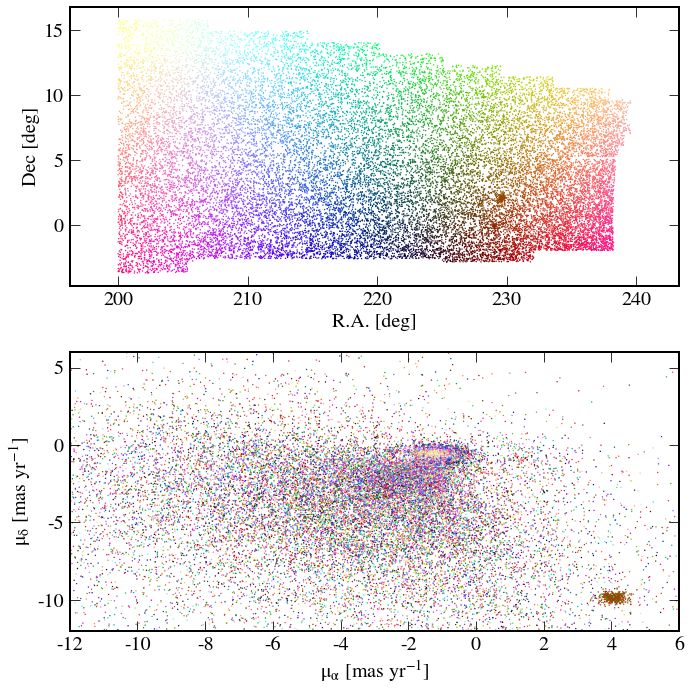

In [204]:
# data color-coded by position
pos_colors = make_colors(data[:, :2])

fig, ax = plt.subplots(2,1,figsize=(10,10))
plt.sca(ax[0])
plt.scatter(data[:,0], data[:,1], c=pos_colors, s=2, edgecolors='none')
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')

plt.sca(ax[1])
plt.scatter(data[:,2], data[:,3], c=pos_colors, s=2, edgecolors='none')
plt.xlim(-12,6)
plt.ylim(-12,6)
plt.xlabel('$\mu_\\alpha$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_\delta$ [mas yr$^{-1}$]')

plt.tight_layout()

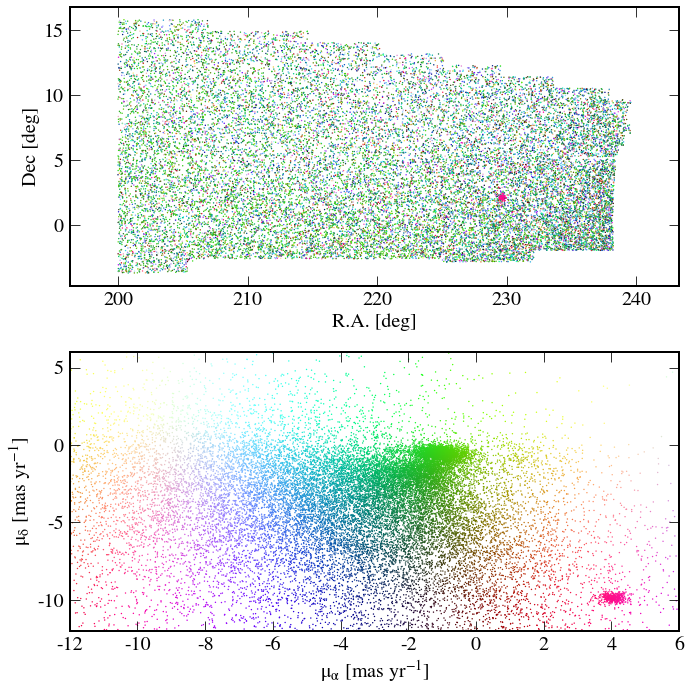

In [205]:
# data color-coded by proper motions
pm_colors = make_colors(data[:, 2:])

fig, ax = plt.subplots(2,1,figsize=(10,10))
plt.sca(ax[0])
plt.scatter(data[:,0], data[:,1], c=pm_colors, s=2, edgecolors='none')
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')

plt.sca(ax[1])
plt.scatter(data[:,2], data[:,3], c=pm_colors, s=2, edgecolors='none')
plt.xlim(-12,6)
plt.ylim(-12,6)
plt.xlabel('$\mu_\\alpha$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_\delta$ [mas yr$^{-1}$]')

plt.tight_layout()

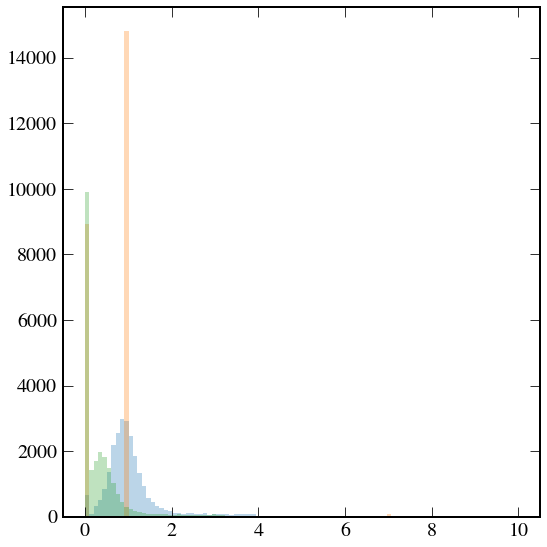

In [207]:
bx = np.linspace(0,10,100)
plt.hist(pm_overdensities- np.percentile(pm_overdensities, 1), bins=bx, alpha=0.3)
plt.hist(pos_overdensities- np.percentile(pos_overdensities, 1), bins=bx, alpha=0.3)

a_ = (1 * (pm_overdensities - np.percentile(pm_overdensities, 10))
      * (pos_overdensities - np.percentile(pos_overdensities, 20)))
plt.hist(a_, bins=bx, alpha=0.3)

plt.tight_layout()

In [192]:
# now set the transparency using the product of the positional and
# proper-motion overdensities
# TONS OF MAGIC HERE
pos_colors[:, 3] = np.clip(0.5 * (pm_overdensities - np.percentile(pm_overdensities, 10))
                           * (pos_overdensities - np.percentile(pos_overdensities, 20)), 0., 1.)
pm_colors[:, 3] = pos_colors[:, 3]

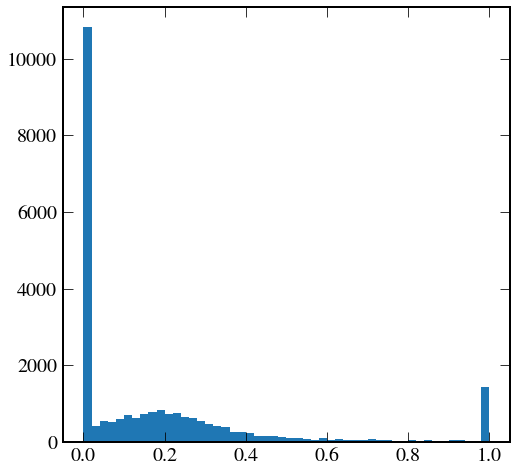

In [193]:
plt.hist(pos_colors[:,3], bins=50);

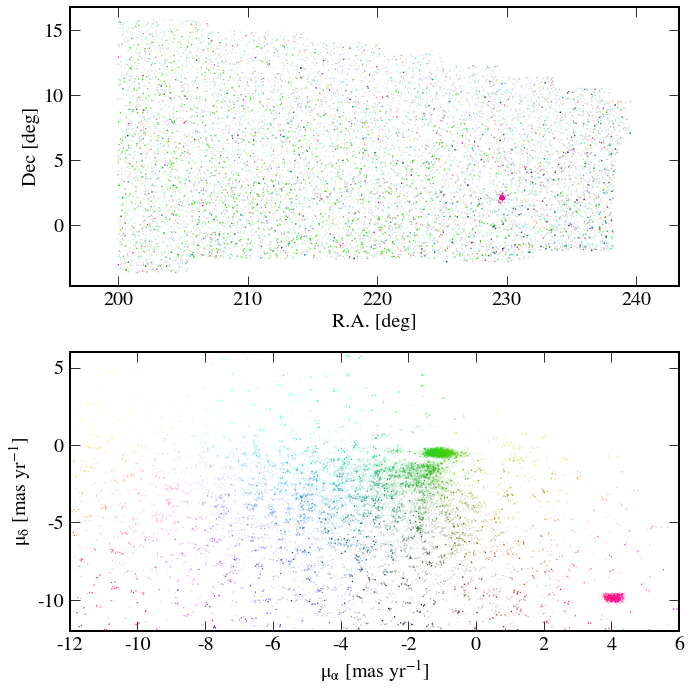

In [198]:
# data color-coded by proper motions, alpha ~ overdensity
fig, ax = plt.subplots(2,1,figsize=(10,10))
plt.sca(ax[0])
plt.scatter(data[:,0], data[:,1], c=pm_colors, s=2, edgecolors='none')
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')

plt.sca(ax[1])
plt.scatter(data[:,2], data[:,3], c=pm_colors, s=2, edgecolors='none')
plt.xlim(-12,6)
plt.ylim(-12,6)
plt.xlabel('$\mu_\\alpha$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_\delta$ [mas yr$^{-1}$]')

plt.tight_layout()